![normalization](https://www.analog.com/-/media/analog/en/app-note-images/data-loader-design-for-max78000-model-training/7600fig02.jpg?imgver=2)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy
from firmware.synthed_net.bearingnet.cwt_verification.utils import *

DATASET_NAME = "ims_bearings"
DATASET_URL = "https://data.nasa.gov/download/brfb-gzcv/application/zip"
TEMP_PATH = os.path.expanduser('~/Downloads') + "/dataset/"


# Download the dataset to temp
os.system("mkdir -p " + TEMP_PATH)

#check if exists first
ZIPPED = TEMP_PATH + DATASET_NAME + ".zip"
if os.path.exists(ZIPPED):
    print("Dataset already downloaded")
else:
    #unzip it inside its own folder
    os.system("wget -q -O " + ZIPPED + " " + DATASET_URL)
    os.system("unzip " + ZIPPED + " -d " + TEMP_PATH + DATASET_NAME)


Wavelib path: /home/sam/Repositories/tinyml/bearings-max78000/firmware/synthed_net/bearingnet/cwt_verification/../../../../../wavelib/python/ 
Dataset already downloaded


In [2]:
assert get_image(np.ones(SAMPLE_LEN)).shape == (INTERP_SIZE, INTERP_SIZE), "Image shape is wrong"

In [3]:
IMS_PATH = TEMP_PATH + DATASET_NAME + "/IMS/"
os.chdir(IMS_PATH)
os.system("ls")

#check if unrar exists
if not os.path.exists("/usr/bin/unrar"):
    print("unrar not installed")
    sys.exit(1)

if not os.path.exists(IMS_PATH + "1/"):
    os.system("mkdir -p " + IMS_PATH + "1/")
    os.system("mkdir -p " + IMS_PATH + "2/")
    os.system("mkdir -p " + IMS_PATH + "3/")

    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/1st_test.rar 1/")
    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/2nd_test.rar 2/")
    os.system("unrar e " + TEMP_PATH + DATASET_NAME + "/IMS/3rd_test.rar 3/")

1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
exp1_b3_ch5_all_data.txt
exp1_b3_ch5_first100k.txt
exp1_b3_ch5_last100k.txt
ims_bearings_test_exp1_b3_labels.pt
ims_bearings_test_exp1_b3_spectrograms.pt
ims_bearings_train_exp1_b3_labels.pt
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf


In [4]:
def downsample_nparray(data, factor=2):
    """
    Downsamples a numpy array by a given factor.

    Parameters
    ----------
    data : array_like
        Input data array.
    factor : int
        Factor by which to downsample the data.

    Returns
    -------
    downsampled_data : array_like
        Downsampled data array.
    """
    downsampled_data = data[::factor]
    
    #normalise 
    downsampled_data = downsampled_data - np.mean(downsampled_data)
    downsampled_data = downsampled_data / np.std(downsampled_data)
    
    return downsampled_data
    

def create_windows(data, window_length=128, overlap_length=32, window_type='rectangular'):
    """
    Creates a list of windows from a numpy array.

    Parameters
    ----------
    data : array_like
        Input data array.
    window_length : int
        Length of the window.
    overlap_length : int
        Length of the overlap between windows.

    Returns
    -------
    windows : list
        List of windows.
    """
    windows = []
    for i in range(0, len(data) - window_length, window_length-overlap_length):
        if window_type == 'hamming':
            coeffs = np.hamming(window_length)
        else:
            coeffs = np.ones(window_length)
            
        windows.append(coeffs * data[i:i + window_length].flatten())
    return np.array(windows)


os.environ['SSQ_GPU'] = '1'
from ssqueezepy import ssq_cwt, ssq_stft, cwt, wavelets
from ssqueezepy.experimental import scale_to_freq

def cwt_features(window):
    #FEATURIZE START
    #downsample window
    window = downsample_nparray(window, factor=2)
    
    cwt_output = wl.cwt(window, MORLET_PARAM, N, J)
    
    #w =('morlet', {'mu': 5})
    #_, Wx, *_ = ssq_cwt(window, wavelet=w, scales='log-piecewise', nv=16, maprange='energy', gamma=0)
        
    #detach tensors from GPU and convert to numpy
    #Wx = np.abs(Wx.cpu().numpy())
    
    #downsample Tx to 64x64
    #Wx = scipy.signal.resample(Wx, 64, axis=0)
    #Wx = scipy.signal.resample(Wx, 64, axis=1)
    
    #min max normalisation
    #features = (Wx - np.min(Wx)) / (np.max(Wx) - np.min(Wx))
    ##FEATURIZE END
    
    return cwt_output
    

def convert_nasa_experiments_to_numpy(ims_path=IMS_PATH, limit=1e10):
    experiment_files = {"1": os.listdir(ims_path + "1/"), "2": os.listdir(ims_path + "2/"), "3": os.listdir(ims_path + "3/")}
    experiments_data = {"1": {"bearing3_values":[],"bearing3_keys":[]} , "2": {"bearing3_values":[],"bearing3_keys":[]}, "3": {"bearing3_values":[],"bearing3_keys":[]}}
    
    #sort experiment files by name
    for experiment in experiment_files:
        experiment_files[experiment] = sorted(experiment_files[experiment])
        
    
    for experiment in experiment_files:
        i=0
        for file in experiment_files[experiment]:
            #print("Converting exp %s file %s" % (experiment, file))
            #load the data in the file
            bearing3_channel = 4 if experiment == "1" else 2
            
            data = np.loadtxt(ims_path + experiment + "/" + file)
            vals = data[:,bearing3_channel]
            
            experiments_data[experiment]['bearing3_values'].append(vals)
            experiments_data[experiment]['bearing3_keys'].append(file)
            i+=1
            
            if i > limit:
                break
        
    print("Converting NASA IMS dataset to spectrograms")
    return experiments_data,experiment_files

In [5]:
experiments_data,experiment_files = convert_nasa_experiments_to_numpy()

Converting NASA IMS dataset to spectrograms


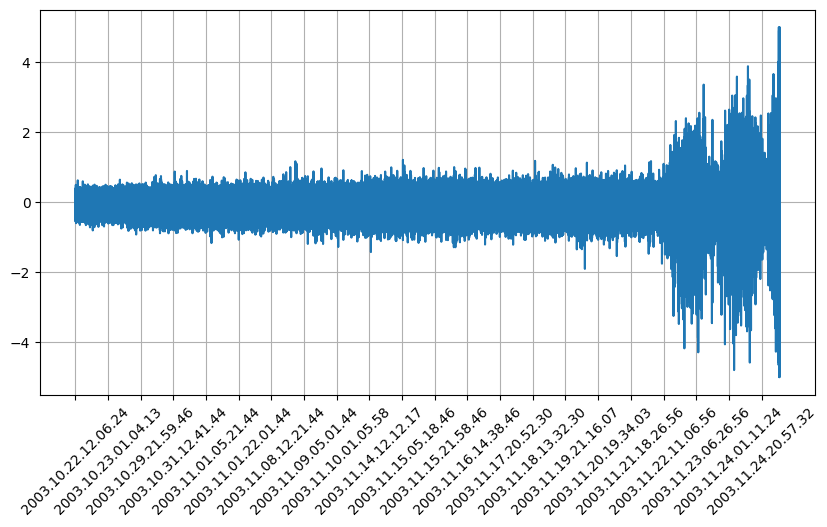

In [6]:
#sanity check
all_data = np.concatenate(experiments_data['1']['bearing3_values'])
xaxis_labels = experiment_files['1']
ds_factor = 100
xaxis_labels = [xaxis_labels[i] for i in range(0, len(xaxis_labels), ds_factor)] #downsample xaxis labels

#plot windows with xaxis labels
plt.figure(figsize=(10, 5))
plt.plot(all_data)

#1 element of xaxis_labels for every 20480 samples
#add xaxis labels
plt.xticks(np.arange(0, len(all_data), ds_factor*20480), xaxis_labels, rotation=45)

#add grid
plt.grid()
plt.show()

In [7]:
np.savetxt("exp1_b3_ch5_first100k.txt", all_data[:100000])
np.savetxt("exp1_b3_ch5_last100k.txt", all_data[-100000:])

### bearing 3 failure labels

from: https://github.com/Miltos-90/Failure_Classification_of_Bearings?tab=readme-ov-file


#### Bearing 3
* early: 2003.10.22.12.06.24 - 2003.11.01.21.41.44
* normal: 2003.11.01.21.51.44 - 2003.11.22.09.16.56
* suspect: 2003.11.22.09.26.56 - 2003.11.25.10.47.32
* Inner race failure: 2003.11.25.10.57.32 - 2003.11.25.23.39.56

In [8]:
early_start = experiment_files['1'].index('2003.10.22.12.06.24')
early_end = experiment_files['1'].index('2003.11.01.21.41.44')
normal_start = experiment_files['1'].index('2003.11.01.21.51.44')
real_normal_end = experiment_files['1'].index('2003.11.22.09.16.56')

my_normal_end = normal_start + 500

start_of_failure_relative_to_suspect = experiment_files['1'].index('2003.11.25.10.57.32') -experiment_files['1'].index('2003.11.22.09.26.56') 

print("Early start: %s" % early_start)
print("Early end: %s" % early_end)
print("Normal start: %s, normal end: %s" % (normal_start, real_normal_end))
print("My normal end: %s" % my_normal_end)
print("Start of failure relative to suspect: %s" % start_of_failure_relative_to_suspect)

Early start: 0
Early end: 498
Normal start: 499, normal end: 1789
My normal end: 999
Start of failure relative to suspect: 330


all_training_sample_spectrograms.shape: (5160, 50, 50)
all_training_labels.shape: (5160,)
startfile: 2003.11.25.10.57.32
endfile: 2003.11.25.23.39.56
all_training_sample_spectrograms.shape: (140, 50, 50)
all_training_labels.shape: (140,)


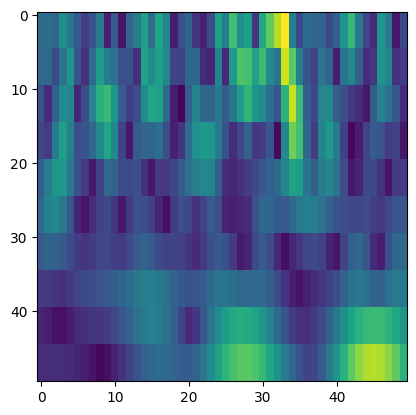

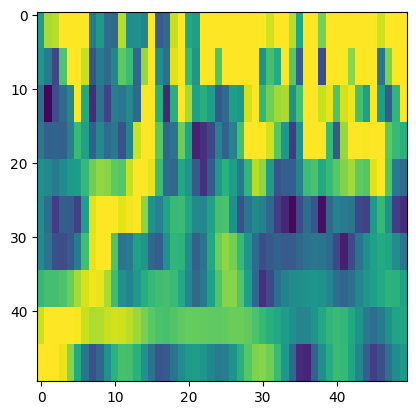

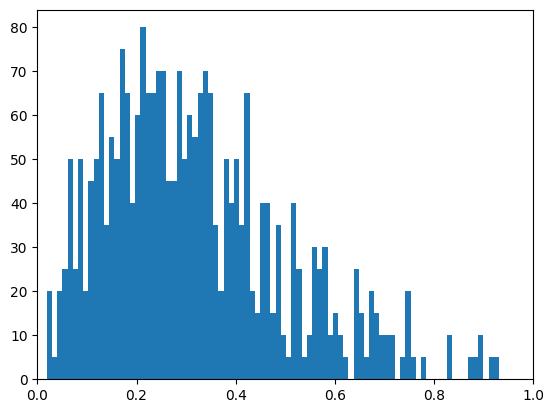

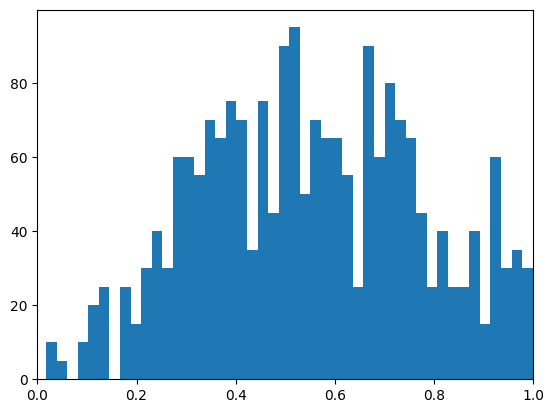

In [14]:
def create_torch_nasa_spectrograms(experiments_data, experiment_files, N=SAMPLE_LEN, wins_to_avg=30, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=False, plot=False):

    if startfile.__class__ == str:
        print("startfile: %s" % startfile)
        print("endfile: %s" % endfile)
        index_start = experiments_data[experiment]['bearing%s_keys'%bearing].index(startfile)
        index_end = experiments_data[experiment]['bearing%s_keys'%bearing].index(endfile)
    else:
        index_start = startfile
        index_end = endfile

    training_files = experiment_files[experiment][index_start:index_end]
    training_data = experiments_data[experiment]['bearing%s_values'%bearing][index_start:index_end]
    training_data = np.stack(training_data) #each row is 1 second of data, taken every 10 minutes

    #generate spectrograms
    all_training_sample_spectrograms = []
    all_training_labels = []
    for i in range(0, len(training_data)):
        #decimate the data
        training_sample_windows = create_windows(training_data[i], window_type='rectangular', window_length=N, overlap_length=0)
        
        for offset in range(0, len(training_sample_windows), wins_to_avg):
            avg_window = np.mean(training_sample_windows[offset:offset+wins_to_avg], axis=0)
            avg_window_image = get_image(avg_window)
            
            #convert to float32
            avg_window_image = avg_window_image.astype(np.float32)
            
            #if ther reference value is well chosen, the data needs to be normalised anymore for training
            # the data will be between 0 and 1
            #therefore no need to normalise
            
            all_training_sample_spectrograms.append(avg_window_image)
            all_training_labels.append(training_files[i])
        
    all_training_sample_spectrograms = np.array(all_training_sample_spectrograms)
    all_training_labels = np.array(all_training_labels)
    
    print("all_training_sample_spectrograms.shape: %s" % str(all_training_sample_spectrograms.shape))
    print("all_training_labels.shape: %s" % str(all_training_labels.shape))
    
    if save:
        print("we have %s normal training samples of %s x %s spectrograms" % (all_training_sample_spectrograms.shape[0], all_training_sample_spectrograms.shape[1], all_training_sample_spectrograms.shape[2]))
        #save the dataset
        torch.save(all_training_sample_spectrograms, "%s_%s_exp%s_b%s_spectrograms.pt" % (DATASET_NAME,name,experiment,bearing))
        torch.save(all_training_labels, "%s_%s_exp%s_b%s_labels.pt" % (DATASET_NAME,name,experiment,bearing))
        os.system("ls")
        
            
    return all_training_sample_spectrograms

train = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = normal_start, endfile= real_normal_end, bearing=3, experiment="1", save=False, plot=True)
test = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="test", startfile = "2003.11.25.10.57.32", endfile= "2003.11.25.23.39.56", bearing=3, experiment="1", save=False, plot=True)


#random index of training set
tridx = np.random.randint(0, len(train))
teidx = np.random.randint(0, len(test))

plt.imshow(train[tridx], vmax=1, vmin=0)
plt.figure()
plt.imshow(test[teidx], vmax=1, vmin=0)
#histograms

plt.figure()
plt.hist(train[tridx].flatten(), bins=100)
plt.xlim(0, 1)
plt.figure()
plt.hist(test[teidx].flatten(), bins=100)
plt.xlim(0, 1)
plt.show()



training set stats
max: 1.4672838, min: 2.2917402e-05, mean: 0.23337433, std: 0.14315899


(array([4.92000e+04, 1.44405e+05, 2.34170e+05, 3.18020e+05, 3.99060e+05,
        4.63660e+05, 5.22015e+05, 5.67860e+05, 5.99870e+05, 6.18535e+05,
        6.28300e+05, 6.30380e+05, 6.16970e+05, 6.02770e+05, 5.78535e+05,
        5.48865e+05, 5.16895e+05, 4.77655e+05, 4.44405e+05, 4.12015e+05,
        3.74470e+05, 3.41365e+05, 3.05755e+05, 2.74870e+05, 2.47655e+05,
        2.21050e+05, 1.97655e+05, 1.74895e+05, 1.55480e+05, 1.39160e+05,
        1.22300e+05, 1.09425e+05, 9.62200e+04, 8.60250e+04, 7.56050e+04,
        6.69500e+04, 6.07800e+04, 5.31650e+04, 4.72700e+04, 4.26100e+04,
        3.65050e+04, 3.28450e+04, 3.04550e+04, 2.60200e+04, 2.39300e+04,
        2.20600e+04, 1.94000e+04, 1.68150e+04, 1.52800e+04, 1.30300e+04,
        1.20450e+04, 1.07000e+04, 9.09500e+03, 7.87000e+03, 7.52000e+03,
        6.41500e+03, 5.88000e+03, 5.24000e+03, 4.41500e+03, 3.95500e+03,
        3.33000e+03, 2.92000e+03, 2.74500e+03, 2.07500e+03, 1.66000e+03,
        1.75500e+03, 1.46500e+03, 1.10500e+03, 1.10

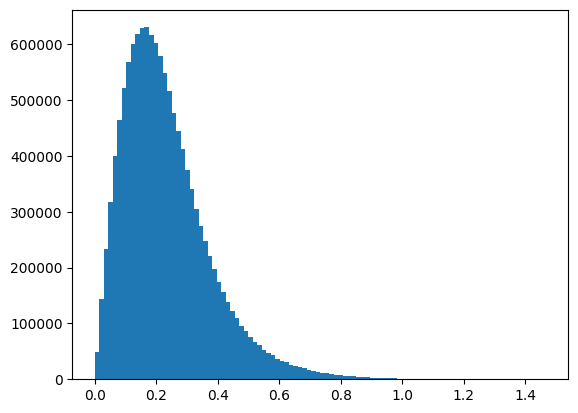

In [15]:
#training set stats
print("training set stats")
print("max: %s, min: %s, mean: %s, std: %s" % (train.max(), train.min(), train.mean(), train.std()))
plt.figure()
plt.hist(train.flatten(), bins=100)

In [16]:
train = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="train", startfile = "2003.11.01.21.51.44", endfile= "2003.11.22.09.16.56", bearing=3, experiment="1", save=True, plot=False) #discard early data
test = create_torch_nasa_spectrograms(experiments_data, experiment_files, name="test", startfile = "2003.11.22.09.26.56", endfile= "2003.11.25.23.39.56", bearing=3, experiment="1", save=True, plot=False) #starts at suspect!

startfile: 2003.11.01.21.51.44
endfile: 2003.11.22.09.16.56
all_training_sample_spectrograms.shape: (5160, 50, 50)
all_training_labels.shape: (5160,)
we have 5160 normal training samples of 50 x 50 spectrograms
1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
exp1_b3_ch5_all_data.txt
exp1_b3_ch5_first100k.txt
exp1_b3_ch5_last100k.txt
ims_bearings_train_exp1_b3_labels.pt
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf
startfile: 2003.11.22.09.26.56
endfile: 2003.11.25.23.39.56
all_training_sample_spectrograms.shape: (1460, 50, 50)
all_training_labels.shape: (1460,)
we have 1460 normal training samples of 50 x 50 spectrograms
1
1st_test.rar
2
2nd_test.rar
3
3rd_test.rar
exp1_b3_ch5_all_data.txt
exp1_b3_ch5_first100k.txt
exp1_b3_ch5_last100k.txt
ims_bearings_test_exp1_b3_labels.pt
ims_bearings_test_exp1_b3_spectrograms.pt
ims_bearings_train_exp1_b3_labels.pt
ims_bearings_train_exp1_b3_spectrograms.pt
Readme Document for IMS Bearing Data.pdf


1.4672839021955557 2.2917402093686947e-05 0.23337427308514938 0.02049448574915171
6.386923381581474 0.00013786283032809707 0.296508791212365 0.042972827761600156


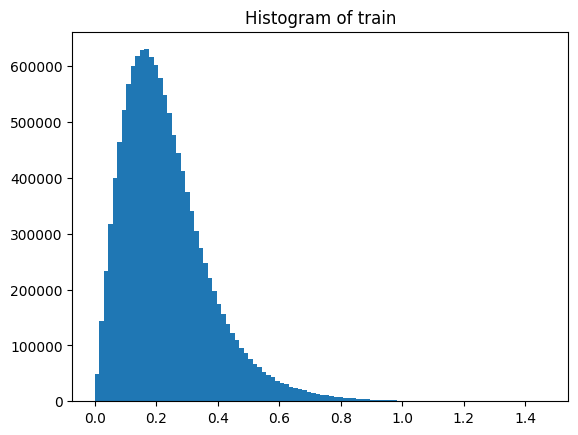

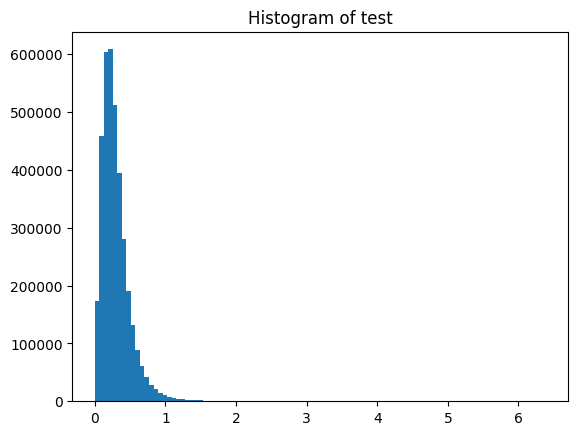

In [12]:
print(train.max(), train.min(), train.mean(), train.var())
print(test.max(), test.min(), test.mean(), test.var())

#histogram of train
plt.hist(train.flatten(), bins=100)
plt.title("Histogram of train")
plt.show()


#histogram of test
plt.hist(test.flatten(), bins=100)
plt.title("Histogram of test")
plt.show()